## ResNet/CNN Prediction of Sharpe Ratio from Generated Images of the Market

### Image Transformation Algorithm for CNN

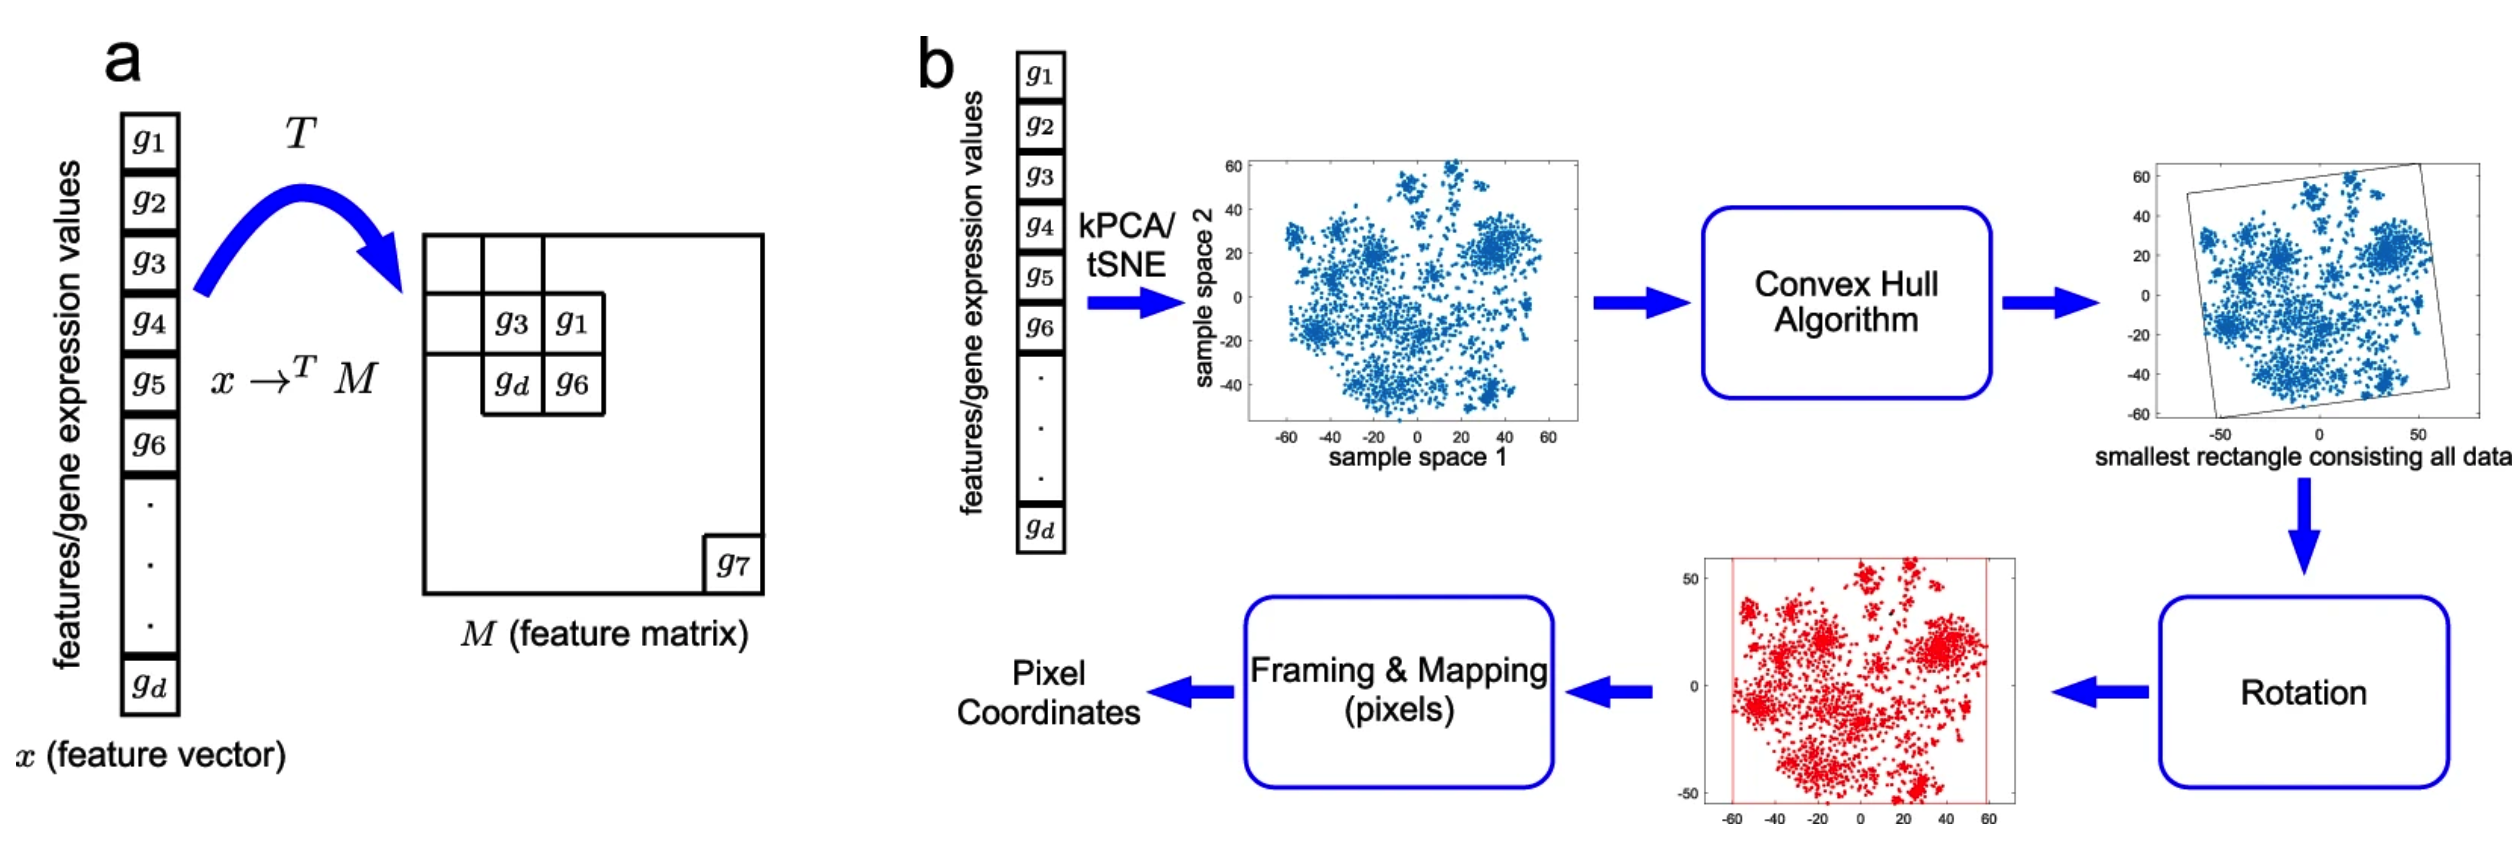

### Imports and Data Retrieval

In [1]:
import pandas as pd
import numpy as np
from pyDeepInsight import ImageTransformer, LogScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

In [9]:
from datetime import datetime
import os
os.chdir('/home/steven/sif')
from sifinfra import sif_utils as su
from matplotlib.ticker import FuncFormatter
import warnings
warnings.filterwarnings('ignore')

In [10]:
start = datetime(2000, 1, 1)
end = datetime(2020, 1, 1)
tickers = sorted(su.get_universe_tickers(100, start, end))
universe_size = len(tickers)
price_attrs = ['open', 'high', 'low','close', 'volume']
data = su.get_equity_data(tickers, start, end, price_attrs)

/home/steven/sif/sif/sifinfra/sif_utils.py:321: DeprecationWarning: execute_query is a deprecated function. sifinfra.sif_utils is a deprecated module and will be removed in a future version of sif. Please remove calls to this module and replace them with alternatives from siftools.data_utils
  cols, response = execute_query(query, params=query_params)
/home/steven/sif/sif/sifinfra/sif_utils.py:253: DeprecationWarning: execute_query is a deprecated function. sifinfra.sif_utils is a deprecated module and will be removed in a future version of sif. Please remove calls to this module and replace them with alternatives from siftools.data_utils
  cols, response = execute_query(query, params=query_params)
/home/steven/sif/sif/sifinfra/sif_utils.py:253: DeprecationWarning: execute_query is a deprecated function. sifinfra.sif_utils is a deprecated module and will be removed in a future version of sif. Please remove calls to this module and replace them with alternatives from siftools.data_utils

### Data Quality Check

In [11]:
change = data['close'][1:50].pct_change(1)
daily_returns = change.iloc[1:,].select_dtypes(exclude="datetime").astype(float)
print(daily_returns.shape)
daily_returns.head()

(48, 267)


ticker,A,AAPL,ABB,ABBV,ABT,ACN,ACTA,ADBE,ADI,ADP,...,WAMUQ,WB1,WBA,WCOEQ,WFC,WLA,WMT,WYE,XOM,YHOO
date,,,,,,,,,,,,,,,,,,,,,
2000-01-05,-0.074286,0.014208,NaN,NaN,-0.005588,NaN,-0.048290,0.017849,0.013080,-0.008462,...,-0.018250,0.012024,0.009091,0.035354,-0.003496,0.014967,-0.023325,0.043887,0.049733,-0.051242
2000-01-06,-0.025341,-0.086207,NaN,NaN,0.039042,NaN,-0.081481,0.010142,-0.025937,0.012219,...,0.029221,0.047524,-0.027027,-0.079259,0.037237,0.014734,0.014011,0.021021,0.056555,-0.123959
2000-01-07,0.083333,0.047170,NaN,NaN,0.010532,NaN,0.121774,0.048581,0.028166,0.022801,...,0.051525,0.018903,0.025556,0.000000,0.017950,0.062691,0.075522,0.051482,-0.002935,0.106192
2000-01-10,0.060615,-0.016892,NaN,NaN,-0.007042,NaN,-0.046729,0.038609,0.087017,0.024541,...,-0.034294,-0.022263,0.029252,-0.007968,-0.031945,-0.015102,-0.018248,-0.046165,-0.014010,0.070710
2000-01-11,-0.013635,-0.051546,NaN,NaN,-0.014184,NaN,-0.136878,-0.068697,-0.041084,-0.019382,...,-0.010172,-0.020888,0.039649,-0.090789,-0.016631,0.003646,-0.014870,-0.026393,0.011940,-0.088741


### Image Transformation Algorithm

The t-SNE technique has two main steps. In the first step, it constructs a probability distribution over
pairs of samples such that similar samples have higher probability and dissimilar samples have lower
probability. In the second step, it finds the probability distribution in a 2D plane. Then it minimizes the
Kullback-Leibler divergence between the two distributions belonging to lower- and higher-dimensional
spaces using a gradient descent method. 

After performing the t-SNE embedding of features, we then use a convex hull algorithm to transform the 2D space into a specific $N x M$ resolution image, such that they can be properly fed into a CNN/ResNet. We then use the feature density (probability) matrix of the result of the convex hull to represent a pixel image.

### Feature Density Matrix

The feature density matrix represents the probability distribution of the features in a 2-dimensional space. This tells us how clustered the tickers are to each other, as the algorithm uses a distance metric between pairs of tickers to choose where they fall in the image-space.

### Tabular to Image Transformation

In [12]:
def image_transform(X):
    # Replace inf's and fill NaN's
    X = X.replace([-np.inf, np.inf], np.nan)
    X = X.fillna(0)
    
    # Initialize transformer objects
    tsne = TSNE(n_components=2, metric='cosine', perplexity = 15,
            random_state=1701, n_jobs=-1)

    it = ImageTransformer(feature_extractor=tsne, pixels=X.shape[1], random_state=1701, 
                          n_jobs=-1)
    
    _ = it.fit(X)
    fdm = it.feature_density_matrix()
    return fdm

fdms = []
for x in price_attrs:
    change = data[x].pct_change(1)
    daily_change = change.iloc[1:,].select_dtypes(exclude="datetime").astype(float)
    daily_change  = daily_change.iloc[: , :128]
    fdm = image_transform(data[x])
    print(fdm.shape)
    fdms.append(np.array(fdm))
    
fdms=np.dstack(fdms)

(267, 267)
(267, 267)
(267, 267)
(267, 267)
(267, 267)


### Plot of Layered Image

In [13]:
import mpl_toolkits.mplot3d.axes3d as axes3d
import matplotlib.pyplot as plot

def cube_marginals(cube, normalize=False):
    c_fcn = np.mean if normalize else np.sum
    xy = c_fcn(cube, axis=0)
    xz = c_fcn(cube, axis=1)
    yz = c_fcn(cube, axis=2)
    return(xy,xz,yz)

def plotcube(cube,x=None,y=None,z=None,normalize=False,plot_front=False):
    (Z,Y,X) = cube.shape
    (xy,xz,yz) = cube_marginals(cube,normalize=normalize)
    if x == None: x = np.arange(X)
    if y == None: y = np.arange(Y)
    if z == None: z = np.arange(Z)

    fig = plot.figure()
    ax = fig.gca(projection='3d')

    offsets = (Z-1,0,X-1) if plot_front else (0, Y-1, 0)
    cset = ax.contourf(x[None,:].repeat(Y,axis=0), y[:,None].repeat(X,axis=1), xy, zdir='z', offset=offsets[0], cmap=plot.cm.coolwarm, alpha=0.75)
    cset = ax.contourf(x[None,:].repeat(Z,axis=0), xz, z[:,None].repeat(X,axis=1), zdir='y', offset=offsets[1], cmap=plot.cm.coolwarm, alpha=0.75)
    cset = ax.contourf(yz, y[None,:].repeat(Z,axis=0), z[:,None].repeat(Y,axis=1), zdir='x', offset=offsets[2], cmap=plot.cm.coolwarm, alpha=0.75)

    ax.plot([0,X-1,X-1,0,0],[0,0,Y-1,Y-1,0],[0,0,0,0,0],'k-')
    ax.plot([0,X-1,X-1,0,0],[0,0,Y-1,Y-1,0],[Z-1,Z-1,Z-1,Z-1,Z-1],'k-')
    ax.plot([0,0],[0,0],[0,Z-1],'k-')
    ax.plot([X-1,X-1],[0,0],[0,Z-1],'k-')
    ax.plot([X-1,X-1],[Y-1,Y-1],[0,Z-1],'k-')
    ax.plot([0,0],[Y-1,Y-1],[0,Z-1],'k-')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plot.show()

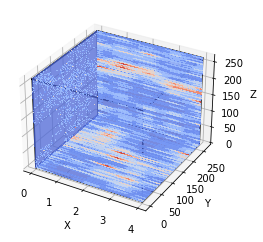

In [14]:
plotcube(np.array(fdms))

### Create Training Dataset

Break data down into size (28,128) chunks, perform image transformation to generate 5-channel image for every chunk, generating only 90 samples for the ResNet to train on. I looked a bit at how the window size impacted performance, I examined that the smaller the window size the more information loss per chunk, resulting in poor performance. Increasing the window size, however, reduces the number of training samples for the ResNet. I found 28 days to be a happy medium with performance, however, in the following sections we will see that it is still not enough data to generalize the model well.

In [15]:
g_synth_data = {}
v_synth_data = {}
daily_change = {}
for v in ['open', 'high', 'low', 'close', 'volume']:
    daily_change[v] = data[v].pct_change(1)
    daily_change[v] = daily_change[v].iloc[1:,]
    daily_change[v] = daily_change[v].loc[:,daily_change[v].apply(pd.Series.nunique) != 1]

In [16]:
np.array([daily_change['open'].apply(pd.Series.nunique) != 1]).all()

True

#### Generate Synthetic Gaussian Data

In [17]:
for v in ['open', 'high', 'low', 'close', 'volume']:
    data[v] = data[v].dropna(axis=1)

In [19]:
import time
g_synth_data = {}
v_synth_data = {}
daily_change = {}
for v in ['open', 'high', 'low', 'close', 'volume']:
    daily_change[v] = data[v].pct_change(1)
    daily_change[v] = daily_change[v].iloc[1:,]

for v in ['open', 'high', 'low', 'close', 'volume']:
    g = Gaussian(3)
    start_time = time.time()
    g.fit(daily_change[v].tail(500))
    print("--- %s seconds to fit Gaussian ---" % (time.time() - start_time))
    start_time = time.time()
    g_synth = g.sample(1000, 'AAPL', 3)
    print("--- %s seconds to sample Gaussian ---" % (time.time() - start_time))
    g_synth_data[v] = g_synth

--- 136.78726196289062 seconds to fit Gaussian ---
--- 27.32394504547119 seconds to sample Gaussian ---
--- 135.53451204299927 seconds to fit Gaussian ---
--- 20.894206047058105 seconds to sample Gaussian ---
--- 138.81156063079834 seconds to fit Gaussian ---
--- 45.21631741523743 seconds to sample Gaussian ---
--- 143.8691954612732 seconds to fit Gaussian ---
--- 36.29869103431702 seconds to sample Gaussian ---
--- 111.73416757583618 seconds to fit Gaussian ---
--- 100.1652603149414 seconds to sample Gaussian ---


#### Append Synthetic Data to Original Data

In [20]:
for v in ['open', 'high', 'low', 'close', 'volume']:
    daily_change[v] = pd.concat([daily_change[v], g_synth_data[v]])

#### Create Market Regime Training Dataset

In [21]:
data = daily_change
n = 10  #chunk row size
list_close = [data['close'][i:i+n] for i in range(0,data['close'].shape[0],n)]
list_open = [data['open'][i:i+n] for i in range(0,data['open'].shape[0],n)]
list_high = [data['high'][i:i+n] for i in range(0,data['high'].shape[0],n)]
list_low = [data['low'][i:i+n] for i in range(0,data['low'].shape[0],n)]
list_volume = [data['volume'][i:i+n] for i in range(0,data['volume'].shape[0],n)]
fdms = []
for i in list(zip(list_close, list_volume, list_high, list_open, list_low)):
    fdm_train = []
    for x in range(5):
        fdm = np.array(image_transform(i[x])).astype('float')
        fdm_train.append(fdm)
    fdm_train = np.asarray(fdm_train)
    fdms.append(fdm_train)
fdms = np.asarray(fdms)

In [22]:
sharpes = []
for x in list_close:
    daily = x
    weights = [1/x.shape[1] for i in range(x.shape[1])]
    daily = (daily*weights).sum(axis=1)
    sharpe = (x.shape[0]**0.5)*(daily.mean()/daily.std())
    sharpes.append(daily.mean()/daily.std())

train_set = pd.DataFrame(list(zip(fdms, sharpes)), columns = ['img', 'sharpe'])
train_set.head()

,img,sharpe
0,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",0.209404
1,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",-0.185305
2,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",0.062001
3,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",0.062774
4,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",0.098683


In [23]:
train_set.shape

(603, 2)

### ResNet Training and Hyperparameter Tuning

AutoKeras ImageClassifier performs internal training, validation, and hyperparameter tuning to evaluate the best ResNet model to fit the data. Below, I use objective of validation accuracy. I train the models on data such that the image at $row_{i}$ is predicting the market regime for $row_{i+1}$. I first tested that the image at $row_{i}$ could predict the market regime of $row_{i}$, which turned out as a success. I then wanted to test how it did at predicting a future window, with the addition of synthetic data generated by a Gaussian copula.

<AxesSubplot:>

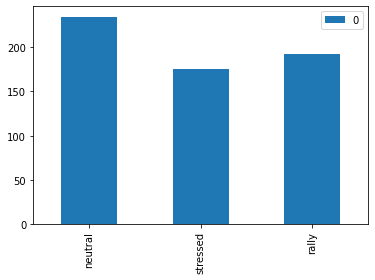

In [27]:
from collections import Counter
labels = ['rally' if x > 0.25 else 'stressed' if x < -0.1 else 'neutral' for x in train_set['sharpe']]
letter_counts = Counter(labels)
df = pd.DataFrame.from_dict(letter_counts, orient='index')
df.plot(kind='bar')

In [33]:
import autokeras as ak
from tensorflow.keras import backend as K

X = np.asarray(fdms)[:-1]
y = np.asarray(np.roll(labels, -1))[:-1]

shuffle = pd.DataFrame(list(zip(X, y)), columns = ['img', 'regime'])
shuffle = shuffle.sample(frac=1)
X = np.asarray(shuffle['img'])
y = np.asarray(shuffle['regime'])


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [56]:
reg = ak.ImageClassifier(max_trials=1, objective='val_accuracy', overwrite=True)

history = reg.fit(X_train, y_train)

Trial 1 Complete [00h 00m 27s]
val_accuracy: 0.6216216087341309

Best val_accuracy So Far: 0.6216216087341309
Total elapsed time: 00h 00m 27s
INFO:tensorflow:Oracle triggered exit
Epoch 1/15
14/14 [==============================] - 1s 50ms/step - loss: 2.1072 - accuracy: 0.3159
Epoch 2/15
14/14 [==============================] - 1s 54ms/step - loss: 0.8881 - accuracy: 0.5843
Epoch 3/15
14/14 [==============================] - 1s 54ms/step - loss: 0.7056 - accuracy: 0.7031
Epoch 4/15
14/14 [==============================] - 1s 54ms/step - loss: 0.4532 - accuracy: 0.9026
Epoch 5/15
14/14 [==============================] - 1s 54ms/step - loss: 0.3337 - accuracy: 0.9430
Epoch 6/15
14/14 [==============================] - 1s 53ms/step - loss: 0.2260 - accuracy: 0.9620
Epoch 7/15
14/14 [==============================] - 1s 54ms/step - loss: 0.1697 - accuracy: 0.9810
Epoch 8/15
14/14 [==============================] - 1s 55ms/step - loss: 0.1240 - accuracy: 0.9834
Epoch 9/15
14/14 [==========

### ResNet Training Trials Summary

In [57]:
reg.tuner.results_summary()

Results summary
Results in ./image_classifier
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
image_block_1/block_type: vanilla
image_block_1/normalize: True
image_block_1/augment: False
image_block_1/conv_block_1/kernel_size: 3
image_block_1/conv_block_1/num_blocks: 1
image_block_1/conv_block_1/num_layers: 2
image_block_1/conv_block_1/max_pooling: True
image_block_1/conv_block_1/separable: False
image_block_1/conv_block_1/dropout: 0.25
image_block_1/conv_block_1/filters_0_0: 32
image_block_1/conv_block_1/filters_0_1: 64
classification_head_1/spatial_reduction_1/reduction_type: flatten
classification_head_1/dropout: 0.5
optimizer: adam
learning_rate: 0.001
Score: 0.6216216087341309


### ResNet Performance and Diagnostics

In [51]:
from sklearn.metrics import accuracy_score
y_pred = reg.predict(X_test)
accuracy = accuracy_score(y_test.astype(str), y_pred.flatten().astype(str))
accuracy

6/6 [==============================] - 0s 24ms/step


0.39226519337016574

In [58]:
np.min(history.history['loss'])

0.03204503282904625

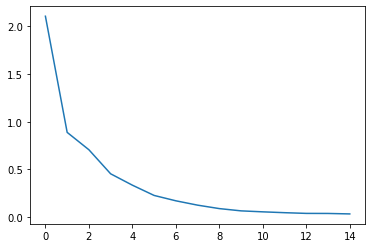

In [59]:
plt.plot(history.history['loss'])